In [1]:
!pip install keras tqdm

In [2]:
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
X = 1.0 * (X > 0.5)

y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)


### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{\sum_{u, g}e^{-E(u, g)}}$$

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$, and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp(vW_{:, i})}$$

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return Activation('sigmoid')(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    1 - probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)



def configuration_goodness_gradient(visible, hidden):
  """
  Gradient of (negative) energy 
  """
  n_samples_norm = K.cast(1 / K.shape(visible)[0], K.floatx())
  return - n_samples_norm * K.dot(
      K.transpose(visible),
      hidden,
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(sample_from_other(W, visible), name='hidden0')
  
  visible_proba1 = probabilities_from_other(K.transpose(W), hidden0)
  visible1 = K.identity(sample_bernoulli(visible_proba1), name='visible1')
  
  hidden1 = K.identity(sample_from_other(W, visible1), name='hidden1')

  return hidden0, visible1, hidden1


def cd1(W, visible):
  hidden0, visible1, hidden1 = cd1_variables(W, visible)
  goodness_gradient0 = configuration_goodness_gradient(visible, hidden0)
  goodness_gradient1 = configuration_goodness_gradient(visible1, hidden1)
  
  return - goodness_gradient0 + goodness_gradient1

### RBM setup

In [0]:
n_visible = X_train.shape[1]
n_hidden = 1000

W_in = K.variable(np.random.randn(n_visible, n_hidden) / 100)
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

In [0]:
lr = 0.02

train_op = K.function(
    inputs=[visible_in],
    outputs=[cd],
    updates=[K.update(W_in, W_in - lr *cd)])

In [7]:
print(K.eval(W_in))

[[-0.00993318  0.00371881  0.01221998 ...  0.00251109  0.01029636
  -0.00544645]
 [-0.00155457  0.00290348  0.01004602 ...  0.0193861   0.00244892
  -0.00687247]
 [ 0.0162835  -0.00392424  0.0028538  ...  0.01363485 -0.00292619
   0.02186296]
 ...
 [-0.00259102 -0.00119336  0.00649896 ...  0.00758652  0.00088023
  -0.02104498]
 [ 0.00689797 -0.00856864  0.00569316 ...  0.00095394 -0.01166575
  -0.0073877 ]
 [-0.00413542  0.00784215  0.00549746 ...  0.01226941 -0.00309738
   0.00529052]]


In [8]:
%%time

minibatch_size = 64
n_epochs = 1000

for __ in tqdm(range(n_epochs)):
  for i in range(X_train.shape[0] // minibatch_size):
    minibatch = X_train[i * minibatch_size:(i+1) * minibatch_size]
    train_op([minibatch])

100%|██████████| 1000/1000 [00:35<00:00, 27.80it/s]

CPU times: user 23.2 s, sys: 8.99 s, total: 32.2 s
Wall time: 36 s


In [9]:
print(K.eval(W_in))

[[-0.01774567 -0.00784371  0.00065748 ... -0.0096764   0.28467172
  -0.02200893]
 [-0.09061698 -0.013034   -0.0052665  ...  0.00344861 -0.11880099
  -0.02437246]
 [ 0.1600337  -0.02267422 -0.0162087  ... -0.00542765 -0.40761533
   0.00842547]
 ...
 [ 0.09772143 -0.01088085 -0.00287605 ... -0.00210097  0.11056766
  -0.01166999]
 [ 0.00221048 -0.01388111  0.00131816 ... -0.00342107  0.06270921
  -0.01207519]
 [-0.09163534  0.00127967  0.00049748 ...  0.0060194   0.2244026
  -0.03689695]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[sample_from_other(W_in, visible_in)]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[sampled_hidden] = sample_hidden_from_visible([X_test])
[sampled_visible] = sample_visible_from_hidden([sampled_hidden])

### Show reconstructed face

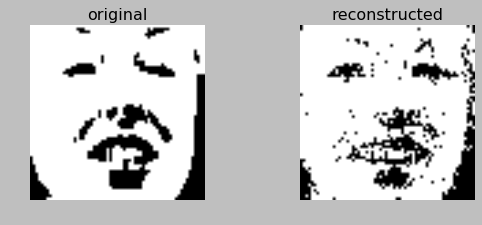

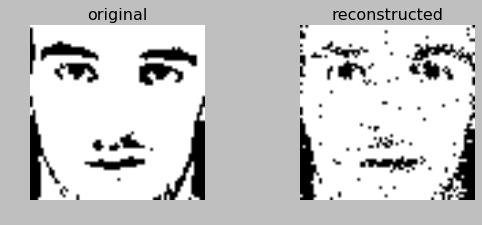

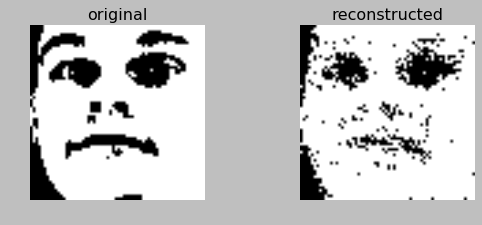

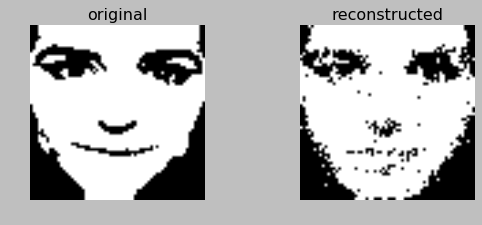

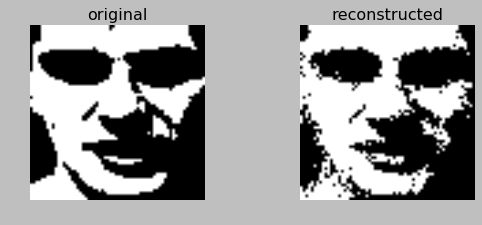

In [20]:
for i in range(5):
  test_face = X_test[i].reshape(64, 64)
  reconstructed_face = sampled_visible[i].reshape(64, 64) 
  
  plt.figure(1)
  plt.subplot(221)
  plt.imshow(test_face, cmap='gray')
  plt.title('original')
  plt.axis('off')
  plt.subplot(222)
  plt.imshow(reconstructed_face, cmap='gray')
  plt.title('reconstructed')
  plt.axis('off')
  plt.show()